In [1]:
import pandas as pd
df = pd.read_csv("../data/processed/industrial_sensor_cleaned.csv")

print("Loaded:", df.shape)
df.head()


Loaded: (8640, 12)


,timestamp,machine_id,temperature,vibration,pressure,speed,maintenance_flag,temp_roll_mean,vib_roll_std,temp_diff,pressure_diff,time_since_last_maint
0,2025-11-01 00:00:00,M01,60.139,0.2986,24.948,1199.06,0,60.1390,0.000000,0.000,0.000,0.0
1,2025-11-01 00:01:00,M01,60.626,0.3184,24.927,1204.27,0,60.3825,0.014001,0.487,-0.021,60.0
2,2025-11-01 00:02:00,M01,60.435,0.3016,24.837,1205.45,0,60.4000,0.010671,-0.191,-0.090,60.0
3,2025-11-01 00:03:00,M01,60.960,0.3277,24.970,1206.71,0,60.5400,0.013838,0.525,0.133,60.0
4,2025-11-01 00:04:00,M01,60.562,0.3346,25.117,1204.08,0,60.5444,0.015800,-0.398,0.147,60.0


In [2]:
# Train/Test Split
from sklearn.model_selection import train_test_split
import os

feature_cols = [
    "temperature", "vibration", "pressure", "speed",
    "temp_roll_mean", "vib_roll_std",
    "temp_diff", "pressure_diff",
    "time_since_last_maint"
]

X = df[feature_cols]
y = df["maintenance_flag"]

# Replace NaN
X = X.fillna(0)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", y_train.value_counts())
print("Test:", y_test.value_counts())

Train: maintenance_flag
0    6893
1      19
Name: count, dtype: int64
Test: maintenance_flag
0    1723
1       5
Name: count, dtype: int64


In [3]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

# sava test data
joblib.dump(X_test, "../models/X_test.pkl")
joblib.dump(y_test, "../models/y_test.pkl")

# Reload the data
X_test = joblib.load("../models/X_test.pkl")
y_test = joblib.load("../models/y_test.pkl")

In [4]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier

#Train Model
model = RandomForestClassifier(
    n_estimators = 300,
    random_state = 42
)

model.fit(X_train, y_train)

#Predict probabilities
y_proba = model.predict_proba(X_test)[:, 1] 

print("Mean probability for normal (0):", y_proba[y_test==0].mean())
print("Mean probability for failure (1):", y_proba[y_test==1].mean())

#Apply Threshold
THRESHOLD = 0.40
y_pred = (y_proba >= THRESHOLD).astype(int)


from sklearn.metrics import classification_report, confusion_matrix

print("Using Threshold =", THRESHOLD)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Mean probability for normal (0): 0.0016270071580576514
Mean probability for failure (1): 0.8786666666666667
Using Threshold = 0.4
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1723
           1       0.83      1.00      0.91         5

    accuracy                           1.00      1728
   macro avg       0.92      1.00      0.95      1728
weighted avg       1.00      1.00      1.00      1728

[[1722    1]
 [   0    5]]


In [5]:
import joblib
import os

# Make sure folder exists
os.makedirs("../models", exist_ok=True)

# Save model
joblib.dump(model, "../models/random_forest_model.pkl")

print("Model saved to: ../models/random_forest_model.pkl")

Model saved to: ../models/random_forest_model.pkl


In [6]:
loaded_model = joblib.load("../models/random_forest_model.pkl")

In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix , f1_score
import numpy as np

# ==========================
# Train XGBoost Model
# ==========================
xgb_model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum()
)

xgb_model.fit(X_train, y_train)

# Predict probabilities
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# ==========================
# Find Best Threshold
# ==========================
thresholds = np.arange(0, 1, 0.01)
f1_scores = []

for th in thresholds:
    y_pred_th = (y_proba_xgb >= th).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_th))

best_th = thresholds[np.argmax(f1_scores)]
print("Best Threshold:", best_th)

# ==========================
# Evaluate model
# ==========================
y_pred_final = (y_proba_xgb >= best_th).astype(int)

print("\n=== XGBoost Results ===")
print(classification_report(y_test, y_pred_final))
print(confusion_matrix(y_test, y_pred_final))

Best Threshold: 0.97

=== XGBoost Results ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1723
           1       1.00      1.00      1.00         5

    accuracy                           1.00      1728
   macro avg       1.00      1.00      1.00      1728
weighted avg       1.00      1.00      1.00      1728

[[1723    0]
 [   0    5]]


In [8]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

joblib.dump(xgb_model, "../models/xgboost_model.pkl")
print("XGBoost model saved successfully!")

XGBoost model saved successfully!


In [9]:
loaded_xgb = joblib.load("../models/xgboost_model.pkl")
print("XGBoost model loaded successfully!")

XGBoost model loaded successfully!


                 feature  importance
6              temp_diff    0.295433
0            temperature    0.190235
1              vibration    0.188457
7          pressure_diff    0.084515
3                  speed    0.082680
4         temp_roll_mean    0.067253
2               pressure    0.054281
5           vib_roll_std    0.037146
8  time_since_last_maint    0.000000


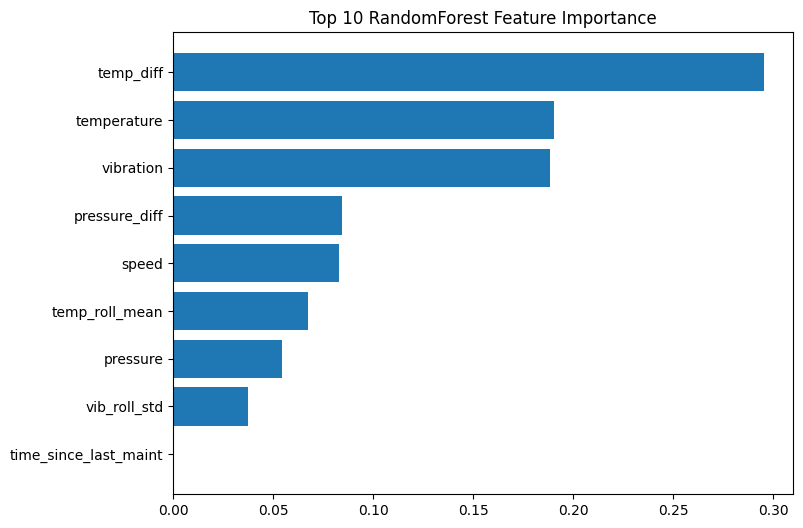

In [10]:
#Feature Importance RandomForest
import pandas as pd
import matplotlib.pyplot as plt

importances_rf = model.feature_importances_
feat_names = X_train.columns

fi_rf = pd.DataFrame({
    "feature": feat_names,
    "importance": importances_rf
}).sort_values("importance", ascending=False)

print(fi_rf)

#Top 10:
fi_rf_top10 = fi_rf.head(10)

#plot
plt.figure(figsize =(8, 6))
plt.barh(fi_rf_top10["feature"], fi_rf_top10["importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 RandomForest Feature Importance")
plt.show()

                 feature  importance
6              temp_diff    0.569186
0            temperature    0.118173
1              vibration    0.111194
4         temp_roll_mean    0.073861
3                  speed    0.056297
5           vib_roll_std    0.041268
7          pressure_diff    0.016146
2               pressure    0.013875
8  time_since_last_maint    0.000000


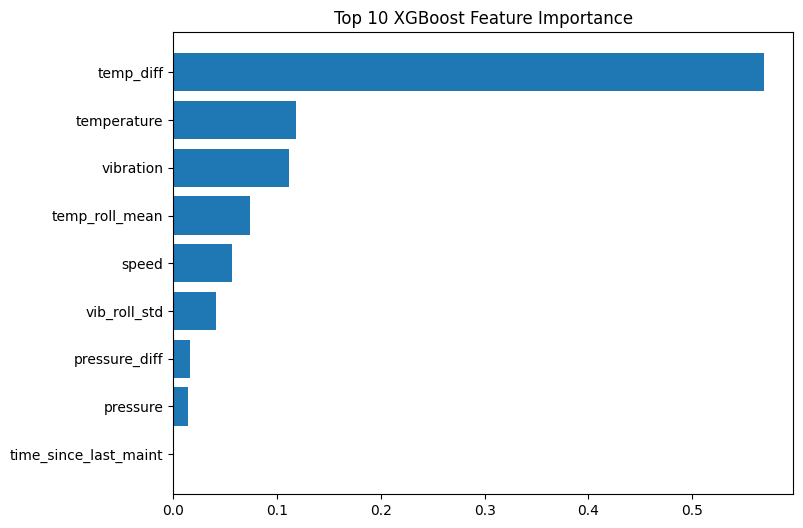

In [11]:
#Feature Importance XGBoost
importances_xgb = xgb_model.feature_importances_
feat_names = X_train.columns

fi_xgb = pd.DataFrame({
    "feature": feat_names,
    "importance": importances_xgb
}).sort_values("importance", ascending = False)

print(fi_xgb)

#plot
plt.figure(figsize =(8, 6))
plt.barh(fi_xgb["feature"][:10], fi_xgb["importance"][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 XGBoost Feature Importance")
plt.show()

In [12]:
#shap rf
import shap
import matplotlib.pyplot as plt

explainer_rf = shap.TreeExplainer(model)
sv_rf = explainer_rf.shap_values(X_test)

if isinstance(sv_rf, list):
    sv_rf = sv_rf[1]

# Summary Plot
plt.figure()
shap.summary_plot(sv_rf, X_test, feature_names=X_test.columns, show=False)
plt.savefig("../results/shap_summary_rf.png", dpi=300, bbox_inches="tight")
plt.close()

# Bar Plot
plt.figure()
shap.summary_plot(sv_rf, X_test, feature_names=X_test.columns, plot_type="bar", show=False)
plt.savefig("../results/shap_bar_rf.png", dpi=300, bbox_inches="tight")
plt.close()

# Dependence Plot
plt.figure()
shap.dependence_plot("temp_diff", sv_rf, X_test, feature_names=X_test.columns, show=False)
plt.savefig("../results/shap_dependence_rf.png", dpi=300, bbox_inches="tight")
plt.close()

print("RF SHAP plots saved successfully!")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


RF SHAP plots saved successfully!


<Figure size 640x480 with 0 Axes>

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


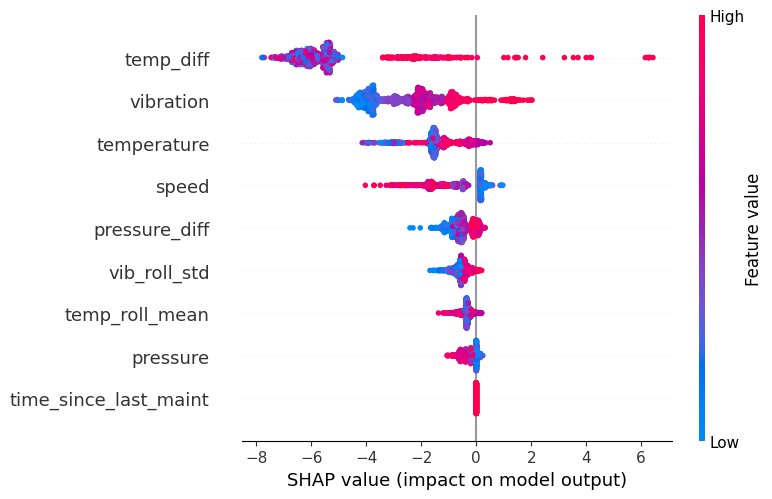

shap_summary_xgb.png saved in results/


In [16]:
#shap XGBoost
import shap
import matplotlib.pyplot as plt

# TreeExplainer
explainer_xgb = shap.TreeExplainer(xgb_model)

# SHAP values
sv_xgb = explainer_xgb.shap_values(X_test)

# Select class 1 if binary classification
if isinstance(sv_xgb, list):
    sv_xgb = sv_xgb[1]

# Summary Plot (show and save)
plt.figure()
shap.summary_plot(sv_xgb, X_test, feature_names=X_test.columns, show=True)
plt.savefig("../results/shap_summary_xgb.png", dpi=300, bbox_inches="tight")
plt.close()

print("shap_summary_xgb.png saved in results/")

In [14]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

metrics = {}

# RandomForest
y_pred_rf = model.predict(X_test)
metrics["RandomForest"] = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1-score": f1_score(y_test, y_pred_rf),
    "ROC-AUC": roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
}

# XGBoost
y_pred_xgb = xgb_model.predict(X_test)
metrics["XGBoost"] = {
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1-score": f1_score(y_test, y_pred_xgb),
    "ROC-AUC": roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])
}

import pandas as pd
df_metrics = pd.DataFrame(metrics)
print(df_metrics)

           RandomForest   XGBoost
Accuracy       0.999421  0.998843
Precision      1.000000  0.714286
Recall         0.800000  1.000000
F1-score       0.888889  0.833333
ROC-AUC        1.000000  1.000000
